# Analisis exploratorio de datos (EDA) Y Modelo de Recomendación
***

#### Importacion de librerias

In [152]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option('max_columns', 30)

Indice:
* Introducción.
* 1. Importación de archivos.
* 2. EDA: Exploración de archivo df_steam.
    * 2.1 Acondicionamiento de datos.
    * 2.2 Distribución de variable numericas.
    * 2.3 Distribución de variables categóricas.
* 3. EDA: Relaciones entre variables.
    * 3.1 Acondicionamiento de datos.
    * 3.2 Cantidad de items vendidos vs precio.
    * 3.3 Cantidad de items vendidos vs género.
    * 3.4 Cantidad de items vendidos vs tags.
    * 3.5 Cantidad de items vendidos vs specs.
* 4. ML : Desarrolo del modelo de recomendación.

### Introducción
En la notebook anterior (ETL) realicé una primera exploración de lo datos, junto con la limpieza y transformaciones necesarias para construir las primeras 6 consultas de la API. En este paso voy a realizar un análisis de los datos pero, con el objetivo de explorarlos para construir a partir de los mismos un modelo de recomendación de videojuegos.
El sistema de recomendación a desarrollar será basado en contenidos (la recomendación se realiza a partir de información extraida de los items).
El df_steam, tiene una lista con valores únicos de items de videojuegos y sus características.
El archivo final_items, tiene una lista de la cantidad de item que compro cada usuario y el tiempo de juego del item.
El archivo final_rev, contiene reseñas de usuarios de algunos de los items y recomendación.

#### 1. Importación de archivos.

In [153]:
final_items = pd.read_csv('final_items.csv')
df_steam=pd.read_csv('df_steam')
final_rev=pd.read_csv('final_rev')

In [154]:
df_steam=pd.read_csv('df_steam')

Para el sistema de recomendación voy a usar principalmente la informacion que este en df_steam, que tiene las caracteristicas de cada juego.

#### 2. Analisis exploratorio de archivo  df_steam.

#### 2.1 Acondicionamiento de datos.

Veo la información del dataframe. 

In [155]:
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      32135 non-null  int64  
 1   publisher       24073 non-null  object 
 2   genres          28852 non-null  object 
 3   app_name        32133 non-null  object 
 4   title           30085 non-null  object 
 5   url             32135 non-null  object 
 6   release_date    29894 non-null  object 
 7   tags            31972 non-null  object 
 8   reviews_url     32133 non-null  object 
 9   discount_price  225 non-null    float64
 10  specs           31465 non-null  object 
 11  price           30752 non-null  float64
 12  early_access    32135 non-null  float64
 13  id              32133 non-null  float64
 14  metascore       2607 non-null   float64
 15  developer       28836 non-null  object 
 16  year            29894 non-null  float64
dtypes: float64(6), int64(1), object

#### Acciones:
  >  **1. Elimino las columnas:**<br>
        * 'Unnamed : No contiene información. <br>
        * 'url': No considero que sea relevante para el modelo. <br>
        * 'reviews_url': No considero que sea relevante para el modelo.<br>
        * 'discount_price': La elimino porque tiene pocos valores.<br>
        * 'metascore': La elimino porque tiene pocos valores.<br>
        * Title: Utilizo la columna app-name para el nombre del videojuego porque 'title' tiene nulos.

In [156]:
df_steam.drop(columns=['Unnamed: 0','url','reviews_url','discount_price','metascore'],inplace=True)

>**2. Las filas que tienen nulos en 'id', y app-name duplicados las elimino.**

In [157]:
df_steam.dropna(subset=['id'], inplace=True)

In [158]:
data_duplicates_df_steam=  df_steam.duplicated( subset=['app_name'],keep="first")
data_duplicates_df_steam.sum()

38

In [159]:
df_steam = df_steam.drop_duplicates( subset=['app_name'],keep="first")

Las variables 'price', 'release_date', 'publisher' y 'developer' presentan valores faltantes pero pueden tenener información relevante para el modelo de recomendación, por lo tanto decido imputar los valores faltantes y luego evaluaremos si serán contempladas en el modelo o eliminadas.

> **3. Acciones: Imputación:** <br>
    * Los columnas con variables numéricas (price y release_date), las imputo con KNN vecinos cercanos<br>
    * las columnas categóricas (publisher y developer), las imputo con la moda.<br>
                                                                         

In [160]:
import numpy as np
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_steam['price_knn'] = imputer.fit_transform(df_steam[['price']])[:,0]

df_steam['release_date']=pd.to_datetime(df_steam['release_date'])
df_steam['release_date'] = imputer.fit_transform(df_steam[['release_date']])[:,0]



In [161]:
moda_developer = df_steam['developer'].mode()[0]
moda_publisher = df_steam['publisher'].mode()[0]
df_steam['developer_moda']=df_steam.developer.fillna(moda_developer)
df_steam['publisher_moda']=df_steam.publisher.fillna(moda_publisher)



In [162]:
df_steam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32095 entries, 0 to 32134
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24042 non-null  object 
 1   genres          28820 non-null  object 
 2   app_name        32094 non-null  object 
 3   title           30050 non-null  object 
 4   release_date    32095 non-null  float64
 5   tags            31934 non-null  object 
 6   specs           31427 non-null  object 
 7   price           30714 non-null  float64
 8   early_access    32095 non-null  float64
 9   id              32095 non-null  float64
 10  developer       28804 non-null  object 
 11  year            29860 non-null  float64
 12  price_knn       32095 non-null  float64
 13  developer_moda  32095 non-null  object 
 14  publisher_moda  32095 non-null  object 
dtypes: float64(6), object(9)
memory usage: 3.9+ MB


In [163]:
df_steam.head(2)

,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,year,price_knn,developer_moda,publisher_moda
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,1.515024e+18,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player'],4.99,0.0,761140.0,Kotoshiro,2018.0,4.99,Kotoshiro,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,1.515024e+18,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult...",0.00,0.0,643980.0,Secret Level SRL,2018.0,0.00,Secret Level SRL,"Making Fun, Inc."


#### 2.2 Análisis de variables numéricas

Aplico la función describe para ver lo parametros estadísticos de las variables numéricas

In [164]:
df_steam.describe()

,release_date,price,early_access,id,year,price_knn
count,3.209500e+04,30714.000000,32095.000000,3.209500e+04,29860.000000,32095.000000
mean,6.879133e+17,8.898680,0.060601,4.517613e+05,2014.764936,8.898680
std,2.713747e+18,16.393233,0.238601,1.827177e+05,3.503253,16.036656
min,-9.223372e+18,0.000000,0.000000,1.000000e+01,1970.000000,0.000000
25%,1.393459e+18,2.990000,0.000000,3.292750e+05,2014.000000,2.990000
50%,1.455235e+18,4.990000,0.000000,4.520600e+05,2016.000000,4.990000
75%,1.490573e+18,9.990000,0.000000,5.934150e+05,2017.000000,9.990000
max,1.640909e+18,995.000000,1.000000,2.028850e+06,2021.000000,995.000000


   * Analizando los valores estadísticos de price y price_knn veo que la imputación no genero grandes cambios en la distribución.
     Por lo tanto considero que es una buena imputación y sigo trabajando con la variable price_knn.
   * En precio parece haber valores muy altos, realizo un boxplot para analizarlo.

<AxesSubplot:xlabel='price'>

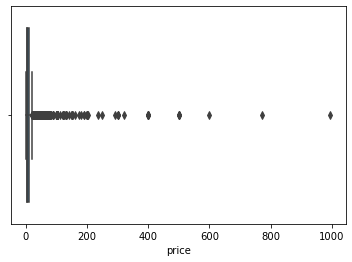

In [165]:
sns.boxplot(data=df_steam, x='price')

El gráfico Boxplot me muestra que price_knn presenta valores extremos. Por lo tanto aplico la regla de los tres sigmas para identificar esos valores e eliminarlos.

In [166]:
media_price_knn = df_steam['price_knn'].mean()
desviacion_estandar_price_knn = df_steam['price_knn'].std()
umbral_knn = 3 * desviacion_estandar_price_knn
df_steam['outlier_price_knn'] = df_steam.apply(lambda x: 1 if (x['price_knn'] > media_price_knn + umbral_knn) | (x['price_knn'] < media_price_knn - umbral_knn) else 0,axis=1)

In [167]:
df_steam.outlier_price_knn.sum()

302

Elimino los valores outliers y observo el nuevo grafico boxplot.

In [168]:
df_steam = df_steam[df_steam['outlier_price_knn'] != 1]

<AxesSubplot:xlabel='price_knn'>

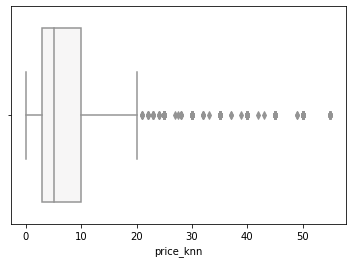

In [169]:
sns.boxplot(data=df_steam, x='price_knn',palette='RdBu_r')

Grafico la distribución de precio imputado, luego de eliminar los valores extremos.

<AxesSubplot:xlabel='price_knn', ylabel='Count'>

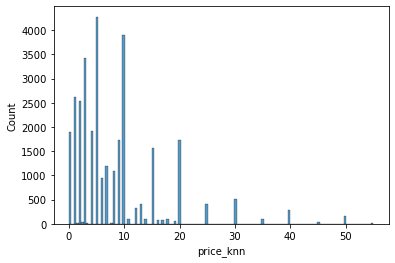

In [170]:
sns.histplot(data=df_steam, x='price_knn')

#### 2.3 Análisis de variables categóricas

Los archivos guardados no tienen las columnas, genero, sepc y tags guardadas como lista sino como str. Para poder luego desanidar esas columnas debemos converir
en tipo 'lista' dichas columnas para realizarlo utilizo la siguiente función:

In [171]:
#Función para convertir una cadena de texto en una lista
def safe_eval(string):
    try:
        return ast.literal_eval(string)
    except (ValueError, SyntaxError):
        return []

Aplico la funcion en las columnas anidadas:

In [172]:
df_steam['specs'] = df_steam['specs'].apply(safe_eval)
df_steam['genres'] = df_steam['genres'].apply(safe_eval)
df_steam['tags'] = df_steam['tags'].apply(safe_eval)

In [173]:
df_steam.head(2)

,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,year,price_knn,developer_moda,publisher_moda,outlier_price_knn
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,1.515024e+18,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0.0,761140.0,Kotoshiro,2018.0,4.99,Kotoshiro,Kotoshiro,0
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,1.515024e+18,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,2018.0,0.00,Secret Level SRL,"Making Fun, Inc.",0


Genero una función para aplanar las listas de las columnas:

In [174]:
def desanidar (feature):
    df = df_steam[[feature,'id']]
    df_exp = df.explode(feature)
    df_exp.dropna(inplace=True)
    return df_exp

**Genero**: El gráfico de conteo de la variable categorica género, no muestra valores extraños. Los generos de Accion, Casual, Indie, Simulation, Strategy, Adventure son los mas comunes y los que contienen mas videojuegos. 

In [175]:
df_genero= desanidar('genres')

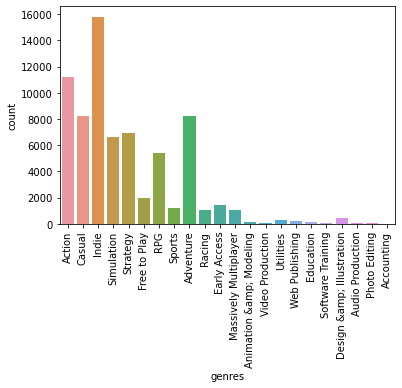

In [176]:
sns.countplot(data=df_genero, x='genres')
plt.xticks(rotation=90)
plt.show()

**Tags**: La variable Tags tiene 339 valores único. Realizo un grafico que muestre las cantidades de 50 categorias para poder tener una idea de como es la distribución. Observo que muchos valores que toma la columna Tags son valores de género.

In [177]:
df_tags= desanidar('tags')

In [178]:
df_tags.tags.nunique()

339

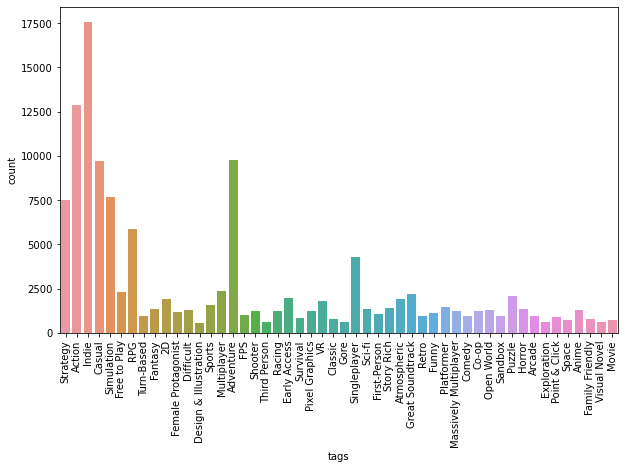

In [179]:
top_50_categories = df_tags['tags'].value_counts().head(50).index
# Filtro el DataFrame para incluir solo las filas con las 10 categorías más comunes
df_filtered = df_tags[df_tags['tags'].isin(top_50_categories)]
# Creo el gráfico de barras con los datos filtrados
plt.figure(figsize=(10, 6))  
sns.countplot(data=df_filtered, x='tags')
plt.xticks(rotation=90) 
plt.show()

**Specs:** Esta variable categorica puede tomar 40 valores diferentes. Realizo un grafico de distibucion.
Vemos que la mayoria de los juegos corresponden a aprox 9 categorias mas importantes.

In [180]:
df_specs= desanidar('specs')

In [181]:
df_specs.specs.nunique()

40

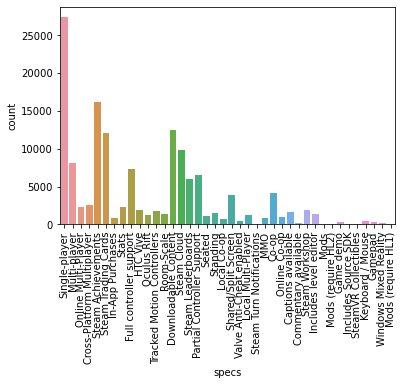

In [182]:
sns.countplot(data=df_specs, x='specs')
plt.xticks(rotation=90)
plt.show()

#### Palabras que mas se repiten en los nomebres de los juegos:
Se realizó un grafico tipo nube de palabras con los títulos de los juegos.

In [183]:
df_steam.app_name.dropna(inplace=True)

In [184]:
df_steam['app_name']=df_steam['app_name'].astype(str)

In [185]:
text = ' '.join(df_steam['app_name'])

In [186]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text)

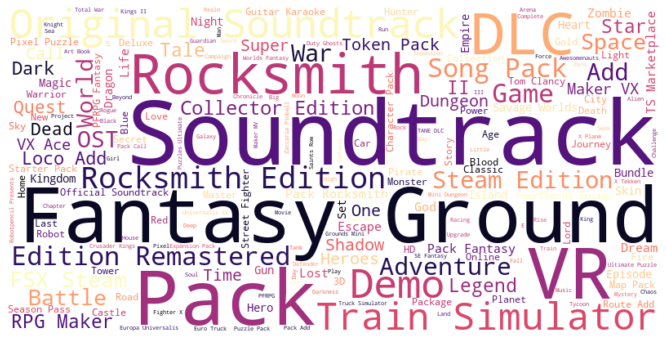

In [187]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Conclusion**: el gráfico nube de palabras no muestra cuales son las palabras mas comunes en los titulos de los videojues:
Soundtrack, VR,PACK,Fantasy etc

### 3. Relaciones entre variables: 

#### 3.1 Acondicionamiento de datos:

***Items consumidos  vs sus caracteristicas***

Agrego información de consumo de items (de final_items) al dataframe df_steam, para analizar relaciones entre las características de los videojuegos y el consumo de los mismos.

Para realizar este analisis, voy a verificar la informacion de consumo de cuantos items tengo. Para ello me fijo los valores únicos que hay en el dataframe final_items. Se tiene información de consumo de 10978 items, pero en la tabla df_steam se tienen 31830 items.
Voy a utilizar la información de consumo para encontrar relaciones entre el consumo de videojuegos y las características de los mismos.


In [188]:
final_items.item_id.nunique()

10978

In [189]:
df_steam.id.nunique()

31793

Aplico una agrupacion por items_id en el dataframe final_items y por agrupacion calculo cantidad de items vendidos y horas jugadas de ese item.
Luego agrego esta informacion al dataset de df_steams.

In [190]:
consumo_items = final_items.groupby('item_id').agg(cantidad = ('item_id','count'),tiempo_juego=('playtime_forever','sum') ).reset_index()

In [191]:
df_steam_consumo = df_steam.merge(consumo_items, left_on='id',right_on='item_id', how='left')

In [192]:
df_steam_consumo.isnull().sum()

publisher             8000
genres                   0
app_name                 0
title                 2031
release_date             0
tags                     0
specs                    0
price                 1381
early_access             0
id                       0
developer             3272
year                  2220
price_knn                0
developer_moda           0
publisher_moda           0
outlier_price_knn        0
item_id              22674
cantidad             22674
tiempo_juego         22674
dtype: int64

Como habia anticipado anteriormente, veo que tengo un gran cantidad de valores faltantes para cantidad y tiempo de juego.
Hago un dataframe nuevo eliminando los registros que no tienen dicha información.

In [193]:
df_steam_consumo.dropna(subset=['item_id'],inplace=True)

#### 3.2 Explorar relación entre variables

> **Precio Vs vcantidad de Items vendidos**

Voy estudiar la relación entre el precio y la cantidad de items vendidos para determinar si es una variable relevante para el usuario a al hora de seleccionar un videojuego.

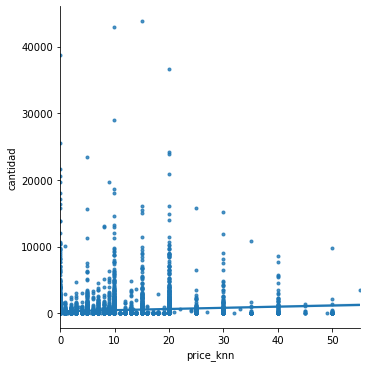

In [194]:
g1 = sns.lmplot(x = 'price_knn', y = 'cantidad', data=df_steam_consumo,
               markers=".")

<AxesSubplot:>

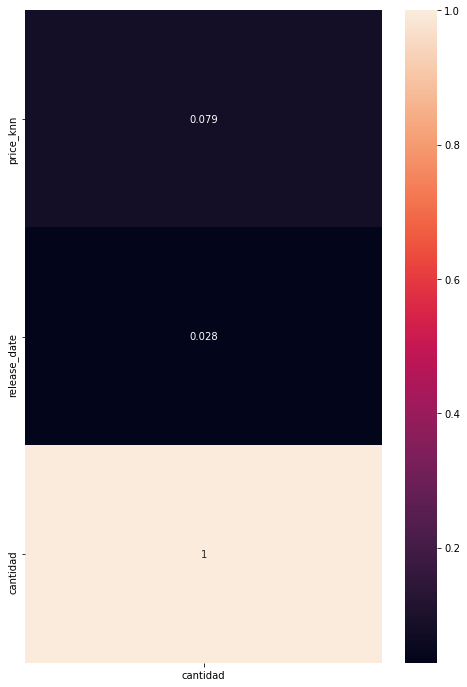

In [195]:
plt.figure(figsize=(8,12))
sns.heatmap(df_steam_consumo[['price_knn','release_date','cantidad']].corr()[['cantidad']], annot=True)

**Conclusión**: La cantidad de items vendidos parece no estar correlacionada con el precio de los videojuegos. Por lo tanto, el precio
no parece ser un factor decisivo a la hora de la elección de un videojuego para el cliente. Por lo tanto no lo tendremos en cuenta en el modelo de recomendación. Tampoco la fecha de lanzamiento del juego parece ser una variable relevante para la eleccion de un videojuego.

> **Género vs cantidad de items vendidos**

*Gráfico de Barras*

In [196]:
genero = df_steam_consumo.explode('genres')


In [197]:
genero_agg=genero.groupby(['genres'])['cantidad'].sum().reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

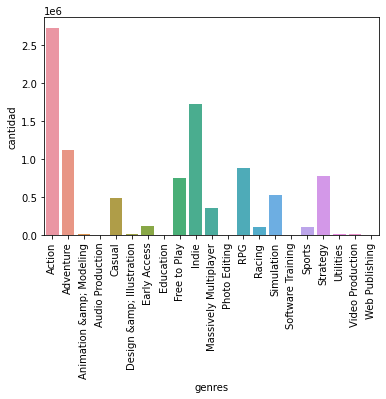

In [198]:
sns.barplot(data=genero_agg, x='genres', y='cantidad')
plt.xticks(rotation=90) 
plt.show

*Grafico de Nube*

In [199]:
genero = df_steam_consumo['genres'].explode('genres')
contador_genero = genero.value_counts()
genero_dic= contador_genero.to_dict()

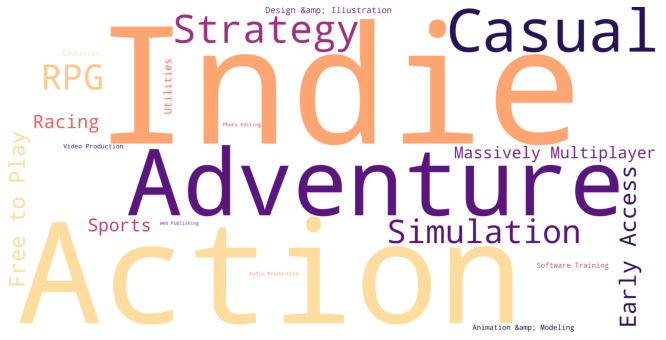

In [200]:
title_wordcloud = WordCloud(background_color='white', height=2000, width=4000, colormap='magma').generate_from_frequencies(genero_dic)
plt.figure(figsize=(12, 6))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

**Conclusión**: De acuerdo a los graficos anteriores, la variable categorica género,  tiene ingerencia en la cantidad de items comprados. Los generos de Action, Casual, Indie, Simulation; Strategy, Adventure son los genero más vendidos. Por lo tanto
el genero parece ser una variable relevante para  el usuario a la hora de  la selección de un videojuego.

> **Tags vs cantidad de items vendidos**

*Grafico nube*

In [201]:
tag = df_steam_consumo['tags'].explode('tags')
contador_tags = genero.value_counts()
tags_dic= contador_tags.to_dict()

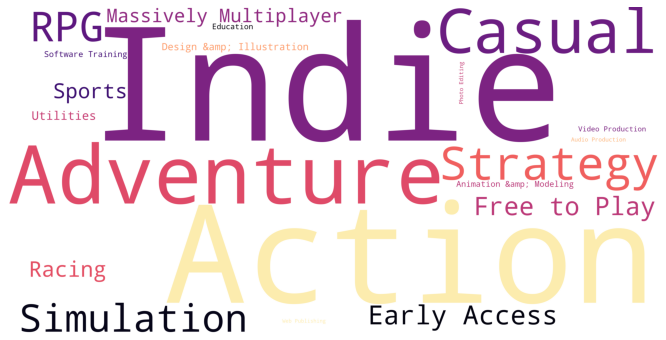

In [202]:
title_wordcloud = WordCloud(background_color='white', height=2000, width=4000, colormap='magma').generate_from_frequencies(tags_dic)
plt.figure(figsize=(12, 6))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

**Conclusión**: la variable categorica Tags,  tiene ingerencia en la cantidad de items comprados. Las etiquetas que aparecen como mas influyentes se corresponden con los géneros. Por lo tanto Genero, como Tags podrian ser redundantes en un sistema de recomendación. Tags  parece ser una variable relevante para  el usuario a la hora de  la selección de un videojuego.

> **Specs vs cantidad de items vendidos**

*Grafico de Barras*

In [203]:
df_steam_consumo.columns

Index(['publisher', 'genres', 'app_name', 'title', 'release_date', 'tags',
       'specs', 'price', 'early_access', 'id', 'developer', 'year',
       'price_knn', 'developer_moda', 'publisher_moda', 'outlier_price_knn',
       'item_id', 'cantidad', 'tiempo_juego'],
      dtype='object')

In [204]:
specs_e = df_steam_consumo.explode('specs')

In [205]:
specs_agg=specs_e.groupby(['specs'])['cantidad'].sum().reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

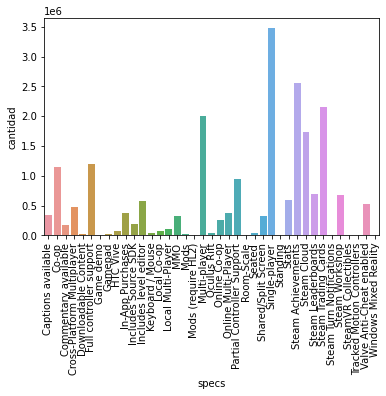

In [206]:
sns.barplot(data=specs_agg, x='specs', y='cantidad')
plt.xticks(rotation=90) 
plt.show

**Conclusión:** la variable categorica Specs, tiene ingerencia en la cantidad de items comprados. 
El consumo de items varia de acuerdo a las especificaciones de cada juego

## MODELO DE RECOMENDACIÓN ML 
***

#### Voy a construir un modelo de recomendacion basado en contenidos. 
Del analisis anterior, considero que Tags es una característica apropiada para tener en cuenta en el sistema de recomendación. Tambien podría incluirse las Specs, pero lo dejaremos para un analisis que escapara a esta etapa inicial de trabajo ya que se cuenta con limitaciones de memoria para el deploy del modelo.

Comenzaré por construir una matriz de caracteristicas para el sistema de recomendación que tenga como columas todos los valores que puede tomar tags. Para cada items las columas que esten presentes en su lista de valores de tags tomaran el valor 1.


### Modelo de recomendación basado en la columna Tags

Hago una lista con los varlores unicos que tiene la etiqueta tags.

In [207]:
tags_u=df_tags.tags.unique().tolist()

Agrego al dataframe df_steam una columna por cada categoria presente en Tags y la completo con 1 si ese item la
contiene y 0 si no la contiene

In [208]:
for i in tags_u:
    df_steam[i]= df_steam.apply(lambda x: 1 if i in x['tags'] else 0,axis=1)

Elimino las columnas que no utilizare en el modelo de reocmendación y reseteo el indice.

In [209]:
df_steam_final=df_steam.drop(columns=['publisher','app_name','genres','title','release_date','tags','specs','price','early_access','id','developer','year','price_knn','developer_moda','publisher_moda','outlier_price_knn']).reset_index(drop=True)

Guardo el dataframe en un archivo parquet para despues poder aplicar la similitud de conseno

In [210]:
df_steam_final.to_parquet('df_steam_final_p')

Reseteo el indice dos veces para tener una columna índex que se corresponda con los indice de df_steam_final

In [211]:
df_steam.reset_index(inplace=True, drop=True)

In [212]:
df_steam.reset_index(inplace=True)

In [213]:
df_steam

,index,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,year,price_knn,developer_moda,...,Word Game,Pool,Conversation,Nonlinear,Spelling,Foreign,Feature Film,Hardware,Steam Machine,Philisophical,Mystery Dungeon,Wrestling,360 Video,Faith,Bikes
0,0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,1.515024e+18,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,0.0,761140.0,Kotoshiro,2018.0,4.99,Kotoshiro,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,1.515024e+18,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,643980.0,Secret Level SRL,2018.0,0.00,Secret Level SRL,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,1.500854e+18,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00,0.0,670290.0,Poolians.com,2017.0,0.00,Poolians.com,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,1.512605e+18,"[Action, Adventure, Casual]",[Single-player],0.99,0.0,767400.0,彼岸领域,2017.0,0.99,彼岸领域,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,NaN,[],Log Challenge,NaN,-9.223372e+18,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,0.0,773570.0,NaN,NaN,2.99,Ubisoft - San Francisco,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31788,31788,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,1.515024e+18,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS""",2018.0,1.99,"Nikita ""Ghost_RUS""",...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31789,31789,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,1.515024e+18,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada,2018.0,4.99,Sacada,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31790,31790,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,1.515024e+18,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich,2018.0,1.99,Laush Dmitriy Sergeevich,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31791,31791,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,1.504310e+18,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns",2017.0,4.99,"xropi,stev3ns",...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Construyo un dataframe que se llama nombre para poder relacionar cada indice con titulo de videouego

In [214]:
df_steam['app_name']=df_steam['app_name'].str.upper()

In [215]:
nombres=df_steam[['index','app_name','id']].copy()
nombres['id']=nombres['id'].astype(int)

In [216]:
nombres.head(3)

,index,app_name,id
0,0,LOST SUMMONER KITTY,761140
1,1,IRONBOUND,643980
2,2,REAL POOL 3D - POOLIANS,670290


Guardo nombres en un archivo parquet

In [217]:
nombres.to_parquet('nombres_id_p')

####  Voy a hacer los pasos que debe hacer la funcion de recomendación previa a construirla

Determino el indice del juego que ingreso a la función por ejemplo '658870'

In [218]:
juego_index=nombres[nombres['id']==658870]['index']

In [219]:
juego_index

31791    31791
Name: index, dtype: int64

In [220]:
juego_index_valor = juego_index.iloc[0]

In [221]:
juego_index_valor 

31791

Utilizo ese indice para caclular la similitud de ese videojuego con el resto de los videojuegos utilizando 
la función cosine_similarity con dos argumentos .Obtengo la lista de indices de los videojuegos que son mas similares a la videojuego que ingrese. 

In [222]:
simil = sorted(enumerate(cosine_similarity(df_steam_final.iloc[[juego_index_valor]], df_steam_final).flatten()), key=lambda x: x[1], reverse=True)[1:6]

In [223]:
simil

[(8129, 0.9128709291752769),
 (31001, 0.9128709291752769),
 (4833, 0.8333333333333336),
 (10088, 0.8333333333333336),
 (14160, 0.8333333333333336)]

Obtengo del dataframe nombres los titulos de esos videojuegos, con los indices anteriores. 

In [224]:
recomendaciones = nombres.iloc[[i[0] for i in simil], :]['app_name'].tolist()

In [225]:
recomendaciones 

['EXIT', 'ZEN BOUND 2', 'LOWGLOW', 'LINEWAY', 'HEX']

#### Haciendo los pasos anteriores genero la funcion de recomendación:

In [226]:
def recomendar(id):
    # determino el indice del juego ingresado
    juego_index=nombres[nombres['id']==id]['index'] 
    # verifico que el juego este en la matriz
    if juego_index.empty:
        return { 'error': 'Game not found' }  
    # tomo el valor del indice
    juego_index_valor = juego_index.iloc[0]
    # calculo la similitud entre se indice y el resto de la matriz y me quedo con  los 5 mas parecidos
    simil = sorted(enumerate(cosine_similarity(df_steam_final.iloc[[juego_index_valor]], df_steam_final).flatten()), key=lambda x: x[1], reverse=True)[1:6]                                                  
    # determino el titulo que le corresponde a los indices
    recomendaciones = nombres.iloc[[i[0] for i in simil], :]['app_name'].tolist()                          
    return recomendaciones

In [227]:
recomendar(658870)

['EXIT', 'ZEN BOUND 2', 'LOWGLOW', 'LINEWAY', 'HEX']

**Conclusion**: Se logró construir un sistema de recomendación basado en las etiquetas de los los videojuegos,

### Modelo de recomendación basado en la columna género

#### Construyo la matriz de caracteristicas ahora basada en la columna género.

Siglo los mismos pasos que en la construcción  de la matrix de caracteristicas con la volumna Tags

In [228]:
df_steam_g=df_steam

In [229]:
df_steam_g.columns

Index(['index', 'publisher', 'genres', 'app_name', 'title', 'release_date',
       'tags', 'specs', 'price', 'early_access',
       ...
       'Foreign', 'Feature Film', 'Hardware', 'Steam Machine', 'Philisophical',
       'Mystery Dungeon', 'Wrestling', '360 Video', 'Faith', 'Bikes'],
      dtype='object', length=356)

In [230]:
genero_u=df_genero.genres.unique().tolist()

In [231]:
for i in genero_u:
    df_steam_g[i]= df_steam_g.apply(lambda x: 1 if i in x['genres'] else 0,axis=1)

In [232]:
df_steam_g_final=df_steam_g.drop(columns=['publisher','genres','app_name','title','release_date','tags','specs','price','early_access','id','developer','year','price_knn','developer_moda','publisher_moda','outlier_price_knn']) 

In [233]:
df_steam_g_final.reset_index(inplace=True, drop=True)

In [234]:
df_steam_g_final.to_parquet('df_steam_g_final')

In [235]:
df_steam_g_final.shape

(31793, 343)

In [236]:
def recomendar_genero(id):
    # determino el indice del juego ingresado
    juego_index=nombres[nombres['id']==id]['index'] 
    # verifico que el juego este en la matriz
    if juego_index.empty:
        return { 'error': 'Game not found' }  
    # tomo el valor del indice
    juego_index_valor = juego_index.iloc[0]
    # calculo la similitud entre se indice y el resto de la matriz y me quedo con  los 5 mas parecidos
    simil = sorted(enumerate(cosine_similarity(df_steam_g_final.iloc[[juego_index_valor]], df_steam_g_final).flatten()), key=lambda x: x[1], reverse=True)[1:6]                                                  
    # determino el titulo que le corresponde a los indices
    recomendaciones = nombres.iloc[[i[0] for i in simil], :]['app_name'].tolist()                          
    return recomendaciones

In [237]:
recomendar_genero(658870)


['ZEN BOUND 2',
 'PUZZLE DIMENSION',
 'ABOUT LOVE, HATE AND THE OTHER ONES',
 'CHAOS THEORY',
 'LUXOR: MAH JONG']

**Conclusión**: Utilizando un modelo de recomendación basado en los géneros, devuelve unos nombres diferentes a los que se obtienen con el modelo basado en las Tags.